# CAICT 風機結冰預測 - Data Exploration

2017/07/20
http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

In [2]:
from IPython.display import HTML
HTML('''<script>
presentation = 0;
code_show=true; 
function code_toggle() {
 if (!presentation){
     return;
 }
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


<a id='home'></a>
### Outline
[1. Modules](#load)  
[2. Input Data](#input)  
[3. Single Variable Exploration](#single)    
[4. Multi-Variable Exploration](#multi)
[5. dimension reduction](#dimen)

<a id='load'></a>
**1. Modules**

- **Python modules:**

In [3]:
%matplotlib inline
import sys
import os
import datetime
import pandas as pd
from PIL import Image
import numpy as np
import lzma
import pickle
from IPython.display import display
import shutil
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import *
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML
from sklearn.decomposition import PCA
from sklearn import preprocessing
from mpl_toolkits import mplot3d
import scipy.stats as stats
import pylab

pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"

- ** data loading and processing modules**

In [4]:

def StandardScaler(data):
    standard_scaler = preprocessing.StandardScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled

def MinMaxScaler(data):
    standard_scaler = preprocessing.MinMaxScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled

def load_resample_data(id, policy=1):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=id,POLICY=policy)
    data_resample = pd.read_csv(filename)
    data_resample['label']=data_resample['label'].fillna(2)
    data_X = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    data_y = data_resample['label']
    data_Y = np.eye(data_y.unique().size)[data_y.values.astype(int)]
    return data_resample, data_X, data_Y, data_y

def load_resample_data_split(id, split_case, policy=1):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=id,POLICY=policy)
    data_resample = pd.read_csv(filename)
    data_resample['label']=data_resample['label'].fillna(2)
    data_resample_train = data_resample[data_resample['event']<split_case]
    data_resample_valid = data_resample[data_resample['event']>=split_case]
    train_X = data_resample_train.drop(['label','time','group','timestamp','event'], axis=1).values
    train_y = data_resample_train['label']
    valid_X = data_resample_valid.drop(['label','time','group','timestamp','event'], axis=1).values
    valid_y = data_resample_valid['label']
    train_Y = np.eye(train_y.unique().size)[train_y.values.astype(int)]
    valid_Y = np.eye(valid_y.unique().size)[valid_y.values.astype(int)]
    return data_resample, train_X, train_Y, train_y, valid_X, valid_Y, valid_y, train_desc, valid_desc


- ** single variable chart modules **

In [6]:
def QQ_plot(data, varlist):
    data_qq_nor = data[data['label']==0]
    data_qq_abnor = data[data['label']==1]
    data_qq_unknown = data[data['label']==2]
    desc = data.describe()
    for idx, var in enumerate(varlist):
        dummy = plt.figure(figsize=[15,5])
        y_min=desc[var]['min']
        y_max=desc[var]['max']

        dummy = plt.subplot(1,4,1)
        res =stats.probplot(data[var],plot=pylab,rvalue=True)
        dummy = plt.title(var+' All')
        dummy = plt.ylim(y_min, y_max)

        dummy = plt.subplot(1,4,2)
        res =stats.probplot(data_qq_nor[var],plot=pylab,rvalue=True)
        dummy = plt.title(var+' Normal')
        dummy = plt.ylim(y_min, y_max)

        dummy = plt.subplot(1,4,3)
        res =stats.probplot(data_qq_abnor[var],plot=pylab,rvalue=True)
        dummy = plt.title(var+' Failure')
        dummy = plt.ylim(y_min, y_max)

        dummy = plt.subplot(1,4,4)
        res =stats.probplot(data_qq_unknown[var],plot=pylab,rvalue=True)
        dummy = plt.title(var+' Unknown')
        dummy = plt.ylim(y_min, y_max)
        pylab.show()


    
def trend_chart(data, event_id, varlist=['label'], tsrange=None, split=False, ma=300):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    for eid in event_id:
        HTML('''<HR>''')
        evtdata = data[data['event']==eid]
        if tsrange is not None:
            evtdata = evtdata[(evtdata['timestamp']>tsrange[0]) & (evtdata['timestamp']<tsrange[-1])]
        evtdata_nor=evtdata[evtdata['label']==0]
        evtdata_abnor=evtdata[evtdata['label']==1]
        evtdata_unknown=evtdata[evtdata['label']==2]

        for var in varlist:
            dummy = plt.figure(figsize=[17,2])
            dummy = plt.plot(evtdata_nor['timestamp'],evtdata_nor[var], color='green',marker='o',ms=1,label='pass')
            dummy = plt.plot(evtdata_unknown['timestamp'],evtdata_unknown[var], color='gray',marker='o',ms=1, label='unknown')
            dummy = plt.plot(evtdata_abnor['timestamp'],evtdata_abnor[var], color='red',marker='o',ms=1, label='fail')
            plt.title('event '+str(eid)+'\t'+var,fontsize='large')
            #dummy = plt.plot(evtdata['timestamp'],pd.rolling_mean(evtdata[var],ma), color='cyan',lw=0.8, label='ma')
            #dummy = plt.plot(evtdata['timestamp'],pd.rolling_std(evtdata[var],ma), color='yellow',lw=0.8)
            dummy = plt.plot(evtdata['timestamp'],pd.ewma(evtdata[var], halflife=ma), color='yellow',lw=0.8, label='ewma')
            #data_diff = evtdata[var] - evtdata[var].shift() 
            #dummy = plt.plot(evtdata['timestamp'],data_diff, color='cyan',lw=0.8, label='diff')
            plt.legend()
            if split: 
                dummy = plt.figure(figsize=[17,2])
                dummy = plt.plot(evtdata_nor['timestamp'],evtdata_nor[var], color='green',marker='o')
                plt.title('event '+str(eid)+'\t'+var+'normal')
                dummy = plt.figure(figsize=[17,2])
                dummy = 0 if evtdata_unknown.empty else plt.plot(evtdata_unknown['timestamp'],evtdata_unknown[var], color='gray',marker='o')
                plt.title('event '+str(eid)+'\t'+var+'unknown')
                dummy = plt.figure(figsize=[17,2])
                dummy = plt.plot(evtdata_abnor['timestamp'],evtdata_abnor[var], color='red',marker='o')
                plt.title('event '+str(eid)+'\t'+var+'failure')
        dummy = plt.show()



        
def box_plot(data, event_id, varx, varylist,fun=sns.violinplot):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    varsize = len(varylist)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        dummy = plt.figure(figsize=[11,4])
        for idx, vary in enumerate(varylist):   
            plt.subplot(1,varsize,idx+1)
            fun(x=varx, y=vary, data=evtdata)
            plt.xlabel(varx)
            plt.ylabel(vary)
            plt.title('event '+str(eid))
        plt.tight_layout()
        plt.show()
            
        
def dist_plot(data,event_id, varlist):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    varsize = len(varlist)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        dummy = plt.figure(figsize=[11,4])
        for idx, var in enumerate(varlist):
            plt.subplot(1,varsize,idx+1)
            evtdata_nor=evtdata[evtdata['label']==0][var]
            evtdata_abnor=evtdata[evtdata['label']==1][var]
            evtdata_unknown=evtdata[evtdata['label']==2][var]
            sns.distplot(evtdata_nor, label='pass', color='g') 
            sns.distplot(evtdata_abnor, label='failure', color='r') 
            dummy = 0 if evtdata_unknown.empty else sns.distplot(evtdata_unknown, label='unknown', color='gray') 
            plt.legend()
            plt.title('event '+str(eid))
        plt.tight_layout()
        plt.show()

def line_chart(data, event_id, varlist):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    plt.figure(figsize=[17,3])
    for eid in event_id:
        evtdata = data[data['event']==eid]
        label_s = evtdata['label']
        evtdata = evtdata[varlist]
        evtdata_nor=evtdata[label_s==0]
        evtdata_abnor=evtdata[label_s==1]
        #evtdata_unknown=evtdata[label_s==2]
        for index, row in evtdata_nor.iterrows():
            dummy = row.plot(color='green', alpha=0.3, lw=0.2)
        for index, row in evtdata_abnor.iterrows():
            dummy = row.plot(color='red', alpha=0.3, lw=0.2)
       # for index, row in evtdata_unknown.iterrows():
       #     dummy = row.plot(color='gray', alpha=0.3, lw=0.2)
        plt.title('event '+str(eid))
        plt.show()

- ** Mmltiple var chart modules**

In [7]:
def scatter_plot(data, event_id, vary, varxlist):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    varsize = len(varxlist)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        evtdata = evtdata[evtdata['label'] !=2]
        levels = [-0.5, 0.5 , 1.5]
        colors = ['green', 'red']
        cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
        desc = data.describe()
        y_min=desc[vary]['min']
        y_max=desc[vary]['max']
        dummy = plt.figure(figsize=[17,5])
        for idx, varx in enumerate(varxlist):
            plt.subplot(1,varsize,idx+1)
            #plt.figure(figsize=[10,8])
            plt.scatter(varx, vary, c='label', edgecolor='none', marker='*', alpha=0.6, data=evtdata,norm=norm, cmap=cmap)
            #plt.colorbar()
            #x_min=desc[varx]['min']
            #x_max=desc[varx]['max']
            #plt.xlim(x_min, x_max)
            #plt.ylim(y_min, y_max)
            plt.title('event '+str(eid))
            plt.xlabel(varx)
            plt.ylabel(vary)
        #plt.tight_layout()
        plt.show()

def sactter_3d(data, event_id, varx, vary, varzlist):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    varsize = len(varzlist)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        evtdata = evtdata[evtdata['label'] !=2]
        levels = [-0.5, 0.5 , 1.5]
        colors = ['green', 'red']
        cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
        dummy = plt.figure(figsize=[15,5])
        for idx, varz in enumerate(varzlist):
            #plt.figure(figsize=[10,8])
            ax = plt.subplot(1,varsize,idx+1, projection='3d')
            ax.scatter3D(evtdata[varx],evtdata[vary],evtdata[varz],c=evtdata['label'], cmap=cmap, norm=norm)
            ax.set_xlabel(varx)
            ax.set_ylabel(vary)
            ax.set_zlabel(varz)
            plt.title('event:'+str(eid))
        plt.show()

<a id='input'></a>
** 2. Input Data **

- data resample policy
    - policy=0: no resample
    - policy=1: event data + normal data (before and after event )
    - policy=2: half event data + normal data (before event only)  
    - policy=3: event data + normal data (before event only)  


In [9]:
#resampled data 
non_data_cols = ['label','time','group','timestamp','event']
data_raw, data_X, _, _ = load_resample_data(id=15,policy=4)
data_scaled = MinMaxScaler(data_X)
for col in non_data_cols:
    data_scaled[col] = data_raw[col]

data = data_scaled
cols=data.columns
cols = cols.drop(['time','timestamp','group','event'])
pd.DataFrame(cols).transpose()
events = data['event'].unique()

0                1      2               3                    4   \
0  wind_speed  generator_speed  power  wind_direction  wind_direction_mean   

             5          6             7             8             9   \
0  yaw_position  yaw_speed  pitch1_angle  pitch2_angle  pitch3_angle   

             10            11            12               13               14  \
0  pitch1_speed  pitch2_speed  pitch3_speed  pitch1_moto_tmp  pitch2_moto_tmp   

                15     16     17               18       19              20  \
0  pitch3_moto_tmp  acc_x  acc_y  environment_tmp  int_tmp  pitch1_ng5_tmp   

               21              22             23             24  \
0  pitch2_ng5_tmp  pitch3_ng5_tmp  pitch1_ng5_DC  pitch2_ng5_DC   

              25     26  
0  pitch3_ng5_DC  label

- ** data info:**

In [11]:
data.describe()

wind_speed  generator_speed         power  wind_direction  \
count  91301.000000     91301.000000  91301.000000    91301.000000   
mean       0.322442         0.364871      0.232604        0.498677   
std        0.135251         0.373779      0.245205        0.114507   
min        0.000000         0.000000      0.000000        0.000000   
25%        0.224592         0.036232      0.041737        0.419464   
50%        0.299247         0.125604      0.114005        0.496605   
75%        0.404015         0.815217      0.385581        0.576575   
max        1.000000         1.000000      1.000000        1.000000   

       wind_direction_mean  yaw_position     yaw_speed  pitch1_angle  \
count         91301.000000  91301.000000  91301.000000  91301.000000   
mean              0.534965      0.304465      0.483763      0.031691   
std               0.088773      0.225748      0.037004      0.073528   
min               0.000000      0.000000      0.000000      0.000000   
25%               0.477260      0.118460      0.475806      0.018893   
50%               0.536479      0.161163      0.483871      0.020918   
75%               0.595319      0.517900      0.491935      0.021592   
max               1.000000      1.000000      1.000000      1.000000   

       pitch2_angle  pitch3_angle  pitch1_speed  pitch2_speed  pitch3_speed  \
count  91301.000000  91301.000000  91301.000000  91301.000000  91301.000000   
mean       0.031115      0.030760      0.573339      0.587222      0.582926   
std        0.073567      0.073695      0.017823      0.017537      0.016916   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.017663      0.017639      0.573298      0.587179      0.582888   
50%        0.019701      0.019674      0.573298      0.587179      0.582888   
75%        0.021739      0.020353      0.573298      0.587179      0.582888   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       pitch1_moto_tmp  pitch2_moto_tmp  pitch3_moto_tmp         acc_x  \
count     91301.000000     91301.000000     91301.000000  91301.000000   
mean          0.280468         0.263786         0.287024      0.491565   
std           0.164890         0.151393         0.160559      0.071029   
min           0.000000         0.000000         0.000000      0.000000   
25%           0.148870         0.141531         0.153124      0.400000   
50%           0.259500         0.245940         0.264263      0.500000   
75%           0.379750         0.357541         0.387750      0.500000   
max           1.000000         1.000000         1.000000      1.000000   

              acc_y  environment_tmp       int_tmp  pitch1_ng5_tmp  \
count  91301.000000     91301.000000  91301.000000    91301.000000   
mean       0.483275         0.436524      0.463362        0.457651   
std        0.049354         0.207744      0.210492        0.230693   
min        0.000000         0.000000      0.000000        0.000000   
25%        0.500000         0.259661      0.296610        0.259091   
50%        0.500000         0.407728      0.427542        0.439394   
75%        0.500000         0.588299      0.630932        0.637879   
max        1.000000         1.000000      1.000000        1.000000   

       pitch2_ng5_tmp  pitch3_ng5_tmp  pitch1_ng5_DC  pitch2_ng5_DC  \
count    91301.000000    91301.000000   91301.000000   91301.000000   
mean         0.469060        0.380777       0.586988       0.559767   
std          0.220705        0.203349       0.159233       0.152628   
min          0.000000        0.000000       0.000000       0.000000   
25%          0.276411        0.185714       0.456250       0.433962   
50%          0.448625        0.370000       0.550000       0.540881   
75%          0.651230        0.542857       0.687500       0.672956   
max          1.000000        1.000000       1.000000       1.000000   

       pitch3_ng5_DC         label         group     timestamp         event  


- ** correlation heatmap **

<function matplotlib.pyplot.tight_layout>

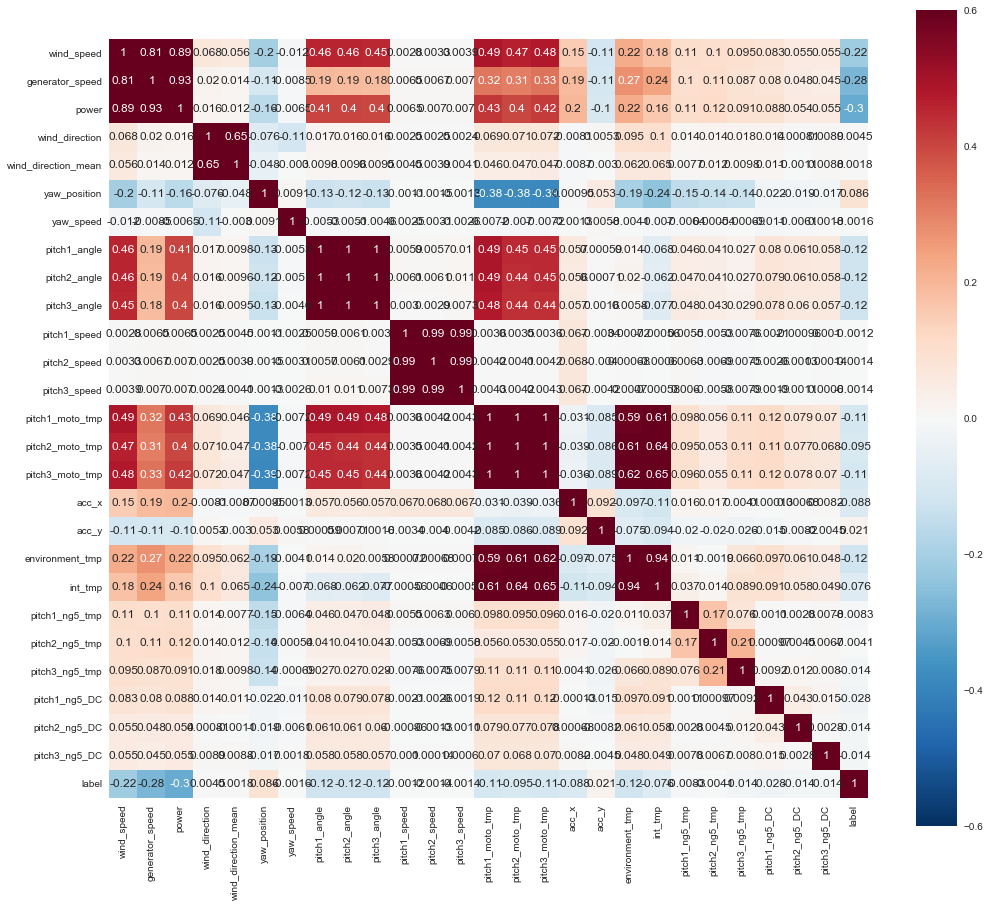

In [14]:
data_heatmap = data[cols]
plt.figure(figsize=(17,15))
foo = sns.heatmap(data_heatmap.corr(), vmax=0.6, square=True, annot=True)
plt.tight_layout

- ** Scatter Plot **
    - y: Power
    - x: all other variable

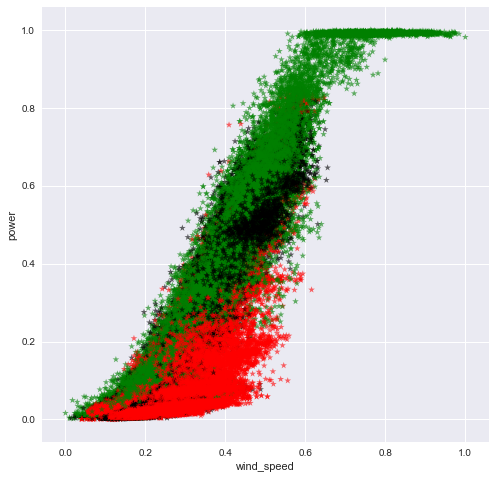

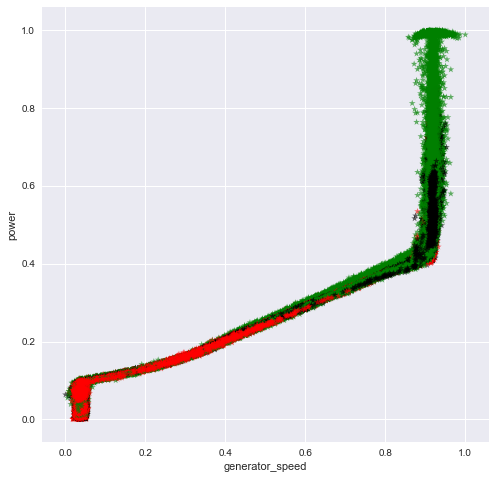

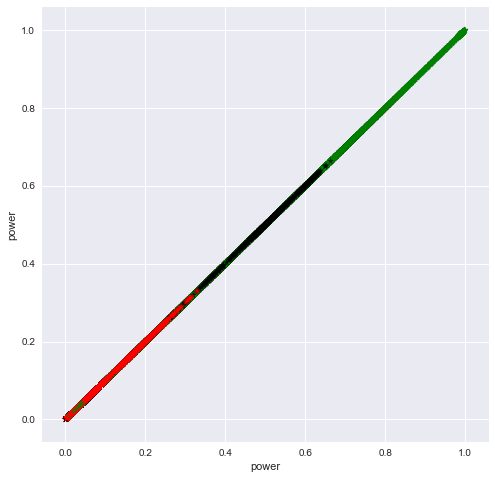

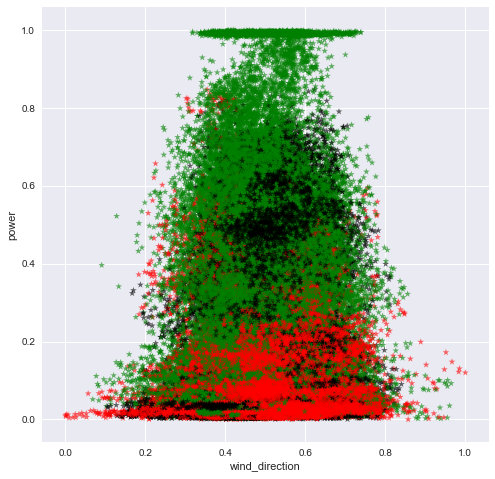

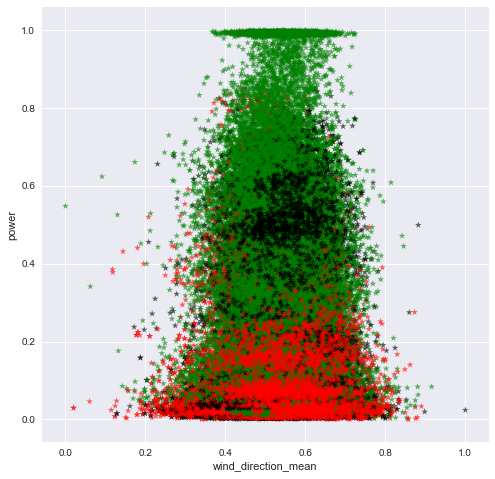

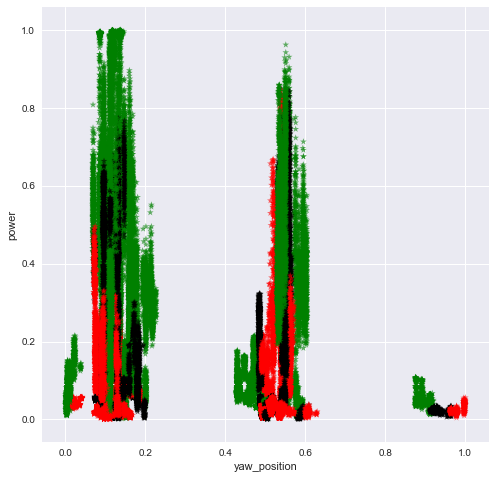

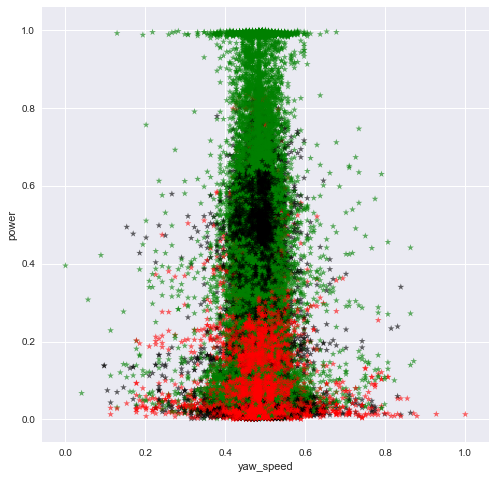

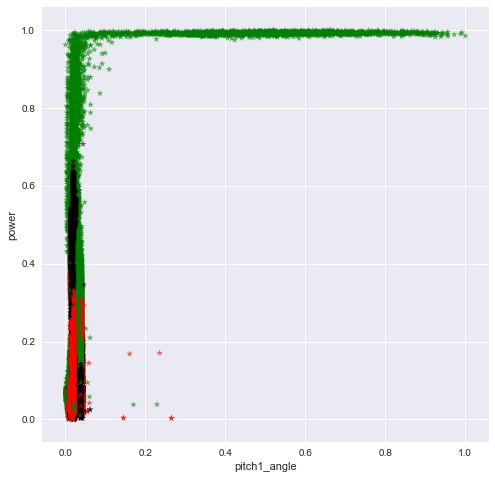

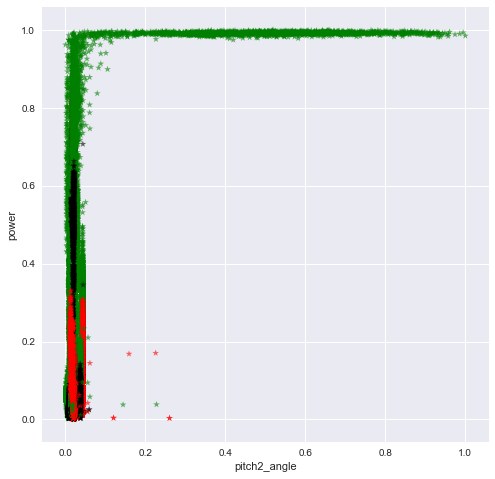

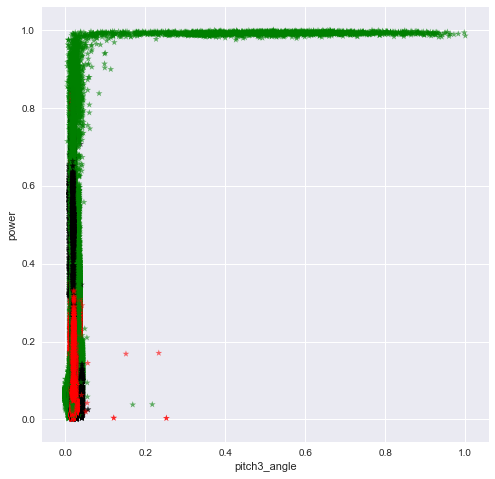

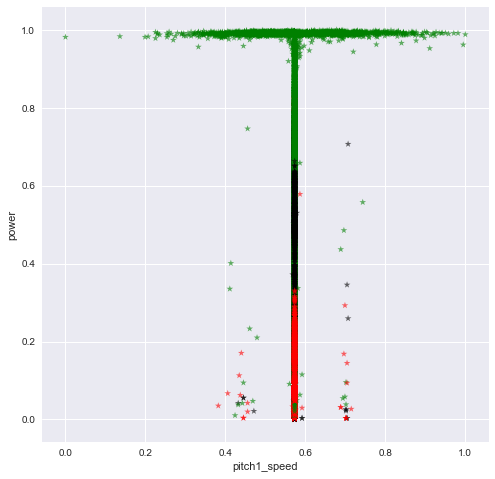

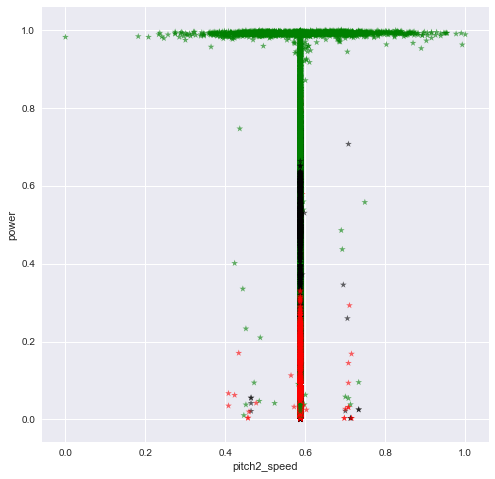

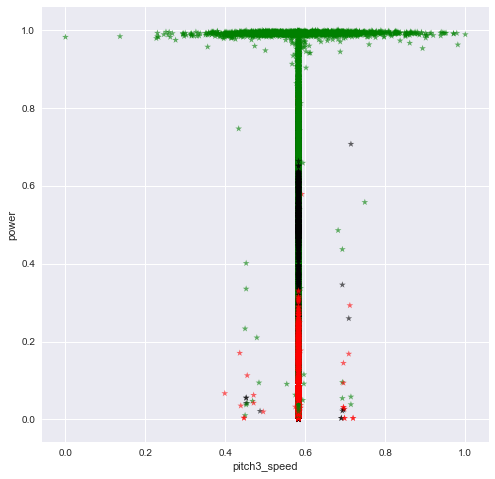

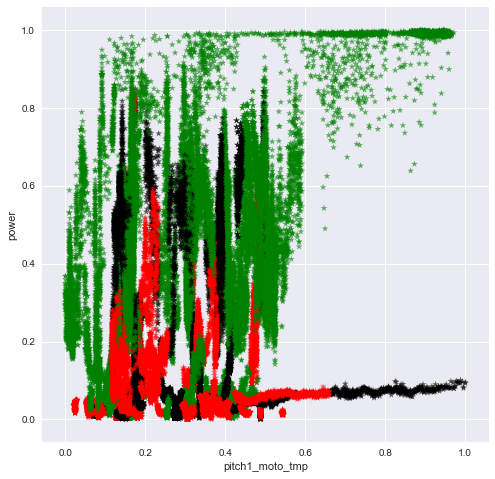

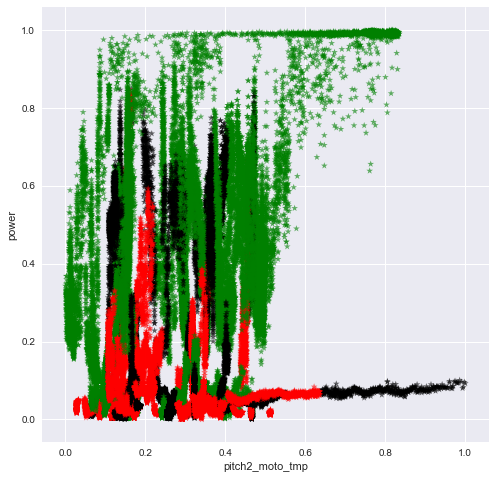

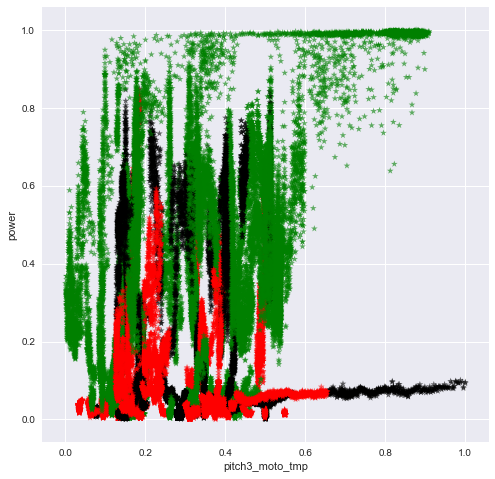

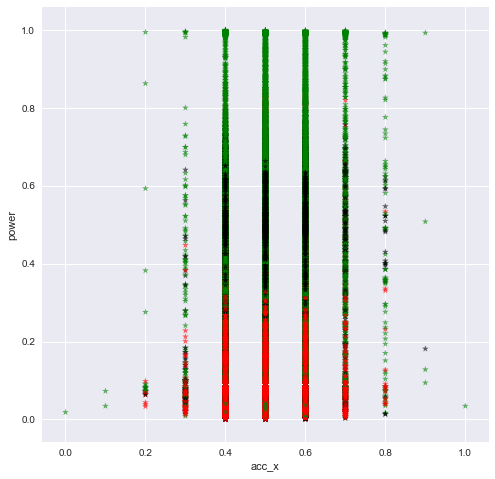

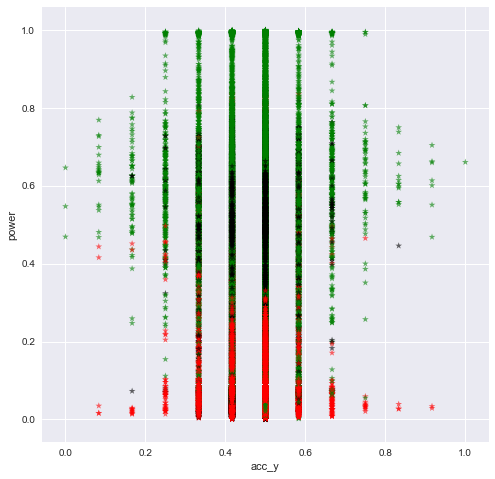

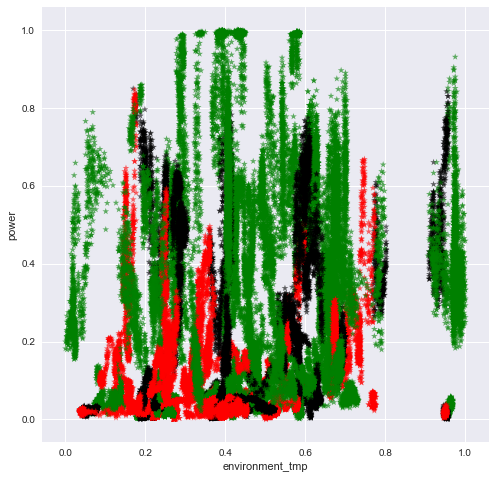

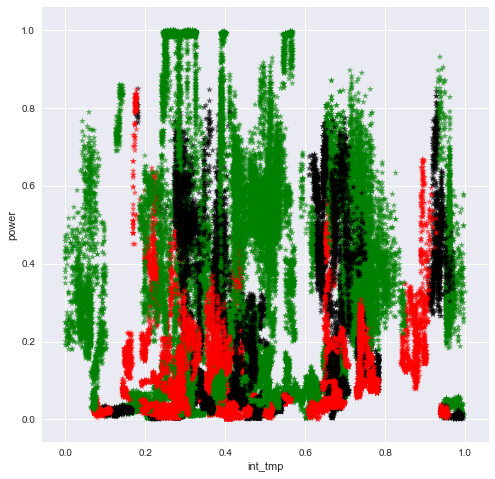

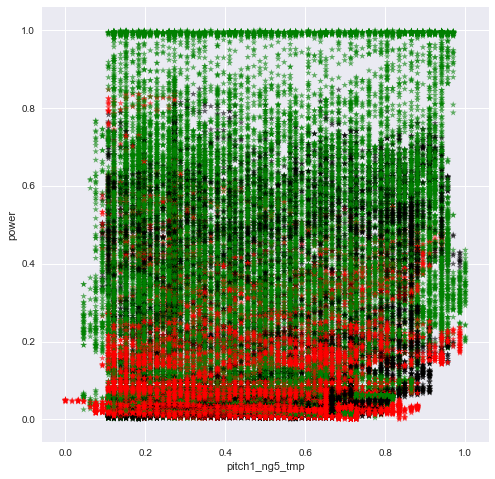

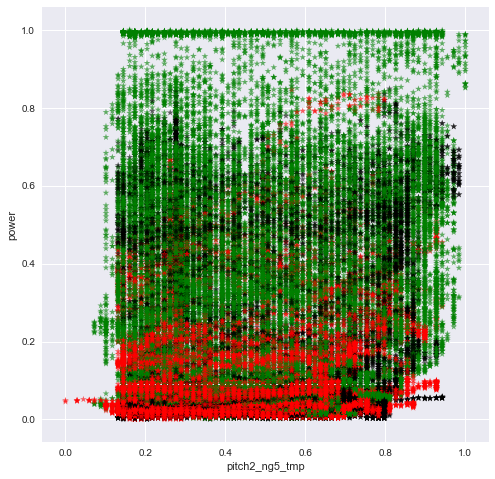

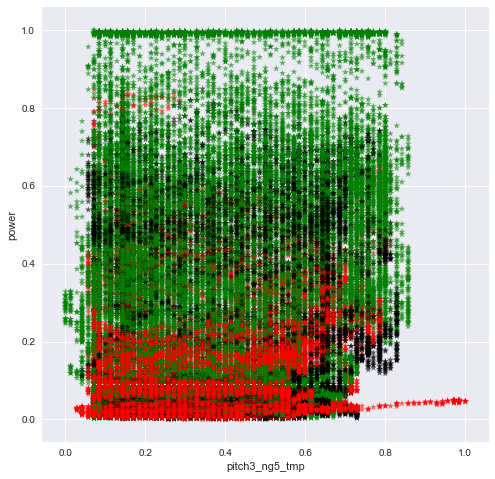

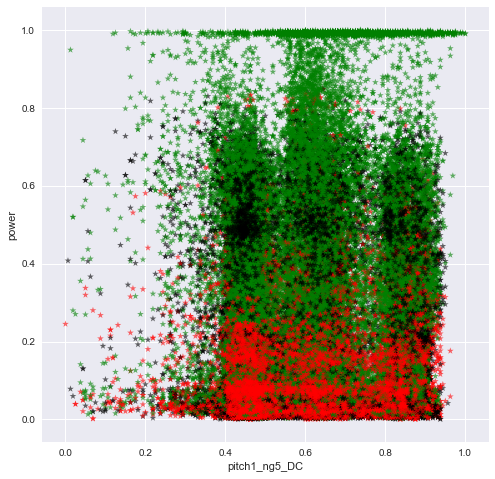

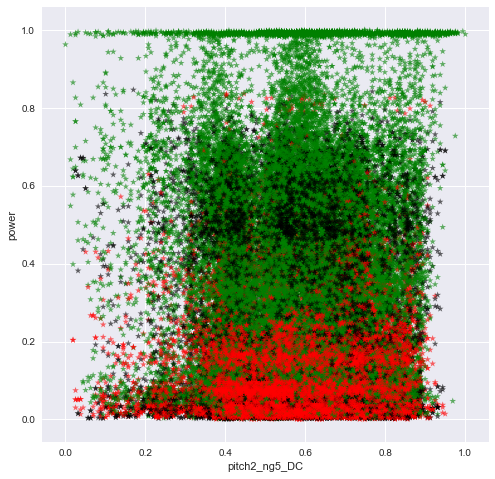

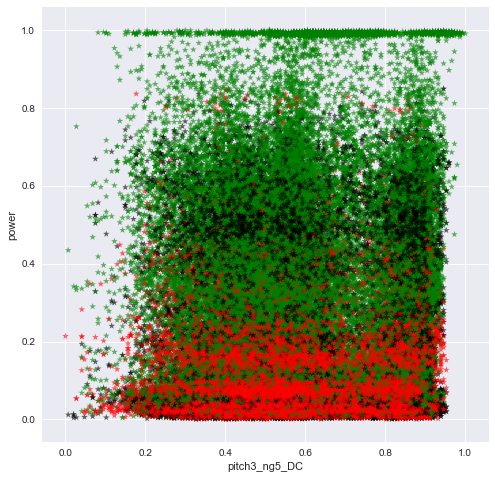

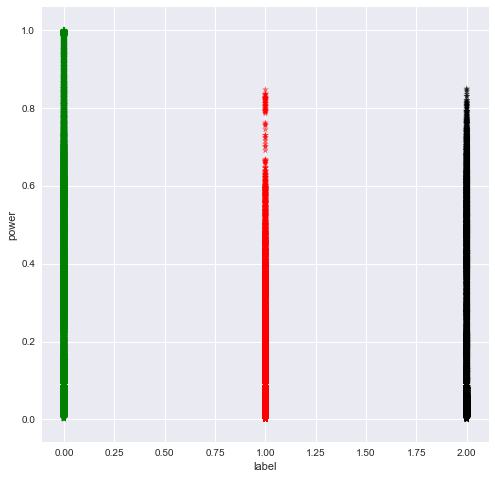

In [13]:
levels = [-0.5, 0.5 , 1.5]
colors = ['green', 'red']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
#plt.scatter(varx, vary, c='label', edgecolor='none', marker='*', alpha=0.6, data=evtdata,norm=norm, cmap=cmap)


for col in cols:
    dummy = plt.figure(figsize=[8,8])
    #data_nor = data[data['label']==0]
    plt.scatter(col, 'power', c='label', edgecolor='none', marker='*', alpha=0.6, data=data,norm=norm, cmap=cmap)
    plt.xlabel(col)
    plt.ylabel('power')
    plt.show()



In [16]:

#scatter_plot(data, event_id=events, vary='power', varxlist=cols)
